In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_absolute_error,mean_squared_error


In [2]:
#load data

data = pd.read_csv("/media/kibria/624309e6-cae1-4eca-a603-4ebc61fc0d9b/data/archive/owid-covid-data.csv")

In [3]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [4]:

# Filter Bangladesh data

bd_data = data[data['location'] == 'Bangladesh'].copy()
bd_data['date'] = pd.to_datetime(bd_data['date'])

In [5]:
# Inspect data shape and columns

print(f"Data shape: {bd_data.shape}")


# Check for missing values
print(bd_data.isnull().sum())

Data shape: (1386, 67)
iso_code                                      0
continent                                     0
location                                      0
date                                          0
total_cases                                  66
                                           ... 
population                                    0
excess_mortality_cumulative_absolute       1386
excess_mortality_cumulative                1386
excess_mortality                           1386
excess_mortality_cumulative_per_million    1386
Length: 67, dtype: int64


In [6]:
# statistics discribe of new caeses

print(bd_data['new_cases'].describe())

count     1385.000000
mean      1477.142960
std       2687.038805
min          0.000000
25%         23.000000
50%        350.000000
75%       1733.000000
max      16230.000000
Name: new_cases, dtype: float64


In [7]:
# # statistics discribe of new death

print(bd_data['new_deaths'].describe())

count    1384.000000
mean       21.302746
std        42.631263
min         0.000000
25%         0.000000
50%         3.000000
75%        27.000000
max       264.000000
Name: new_deaths, dtype: float64


In [8]:
# Number of days with zero cases

zero_cases = (bd_data['new_cases'] == 0).sum()
print(f"Days with zero new cases: {zero_cases}")

Days with zero new cases: 82


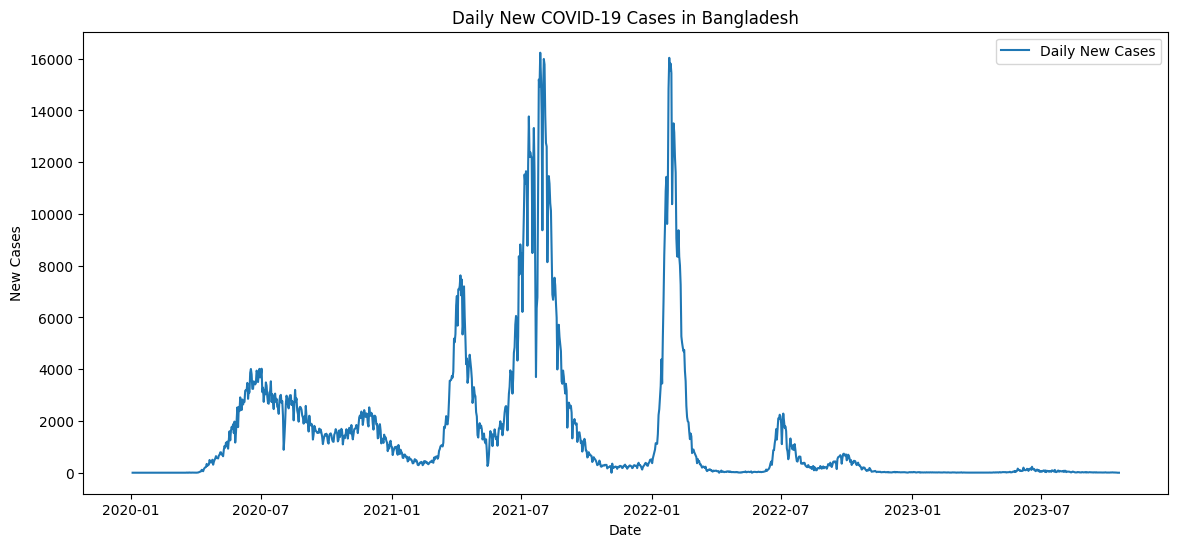

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.lineplot(x='date', y='new_cases', data=bd_data, label='Daily New Cases')
plt.title('Daily New COVID-19 Cases in Bangladesh')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.show()


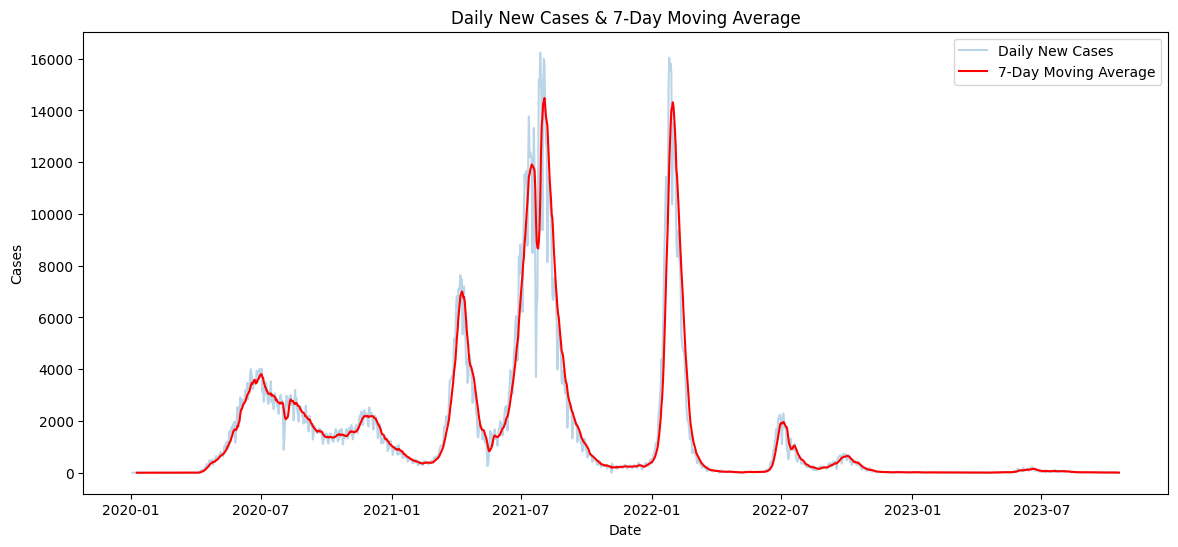

In [10]:
bd_data['new_cases_ma7'] = bd_data['new_cases'].rolling(window=7).mean()

plt.figure(figsize=(14,6))
sns.lineplot(x='date', y='new_cases', data=bd_data, alpha=0.3, label='Daily New Cases')
sns.lineplot(x='date', y='new_cases_ma7', data=bd_data, label='7-Day Moving Average', color='red')
plt.title('Daily New Cases & 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()


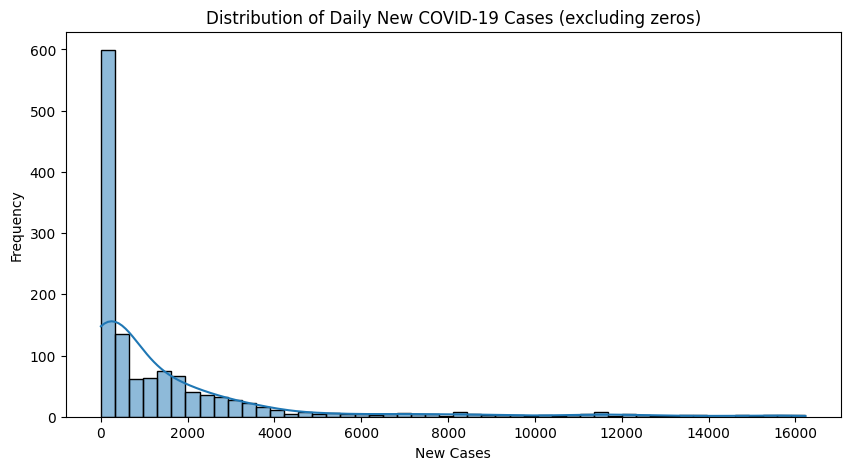

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(bd_data['new_cases'][bd_data['new_cases'] > 0], bins=50, kde=True)
plt.title('Distribution of Daily New COVID-19 Cases (excluding zeros)')
plt.xlabel('New Cases')
plt.ylabel('Frequency')
plt.show()


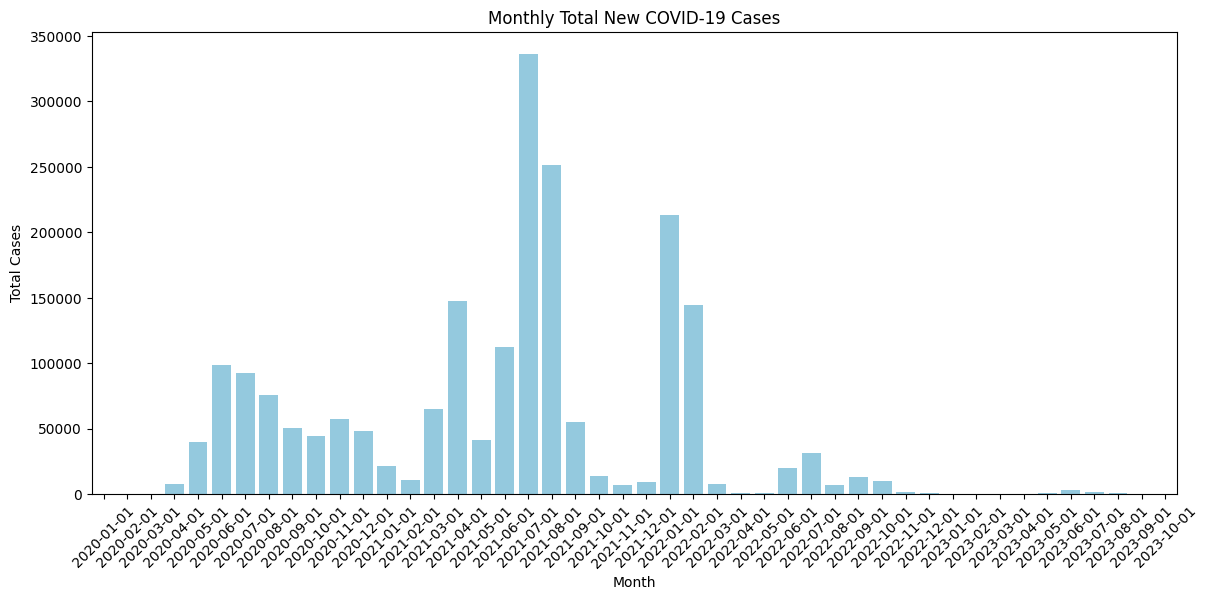

In [12]:
bd_data['month'] = bd_data['date'].dt.to_period('M')
monthly_cases = bd_data.groupby('month')['new_cases'].sum().reset_index()
monthly_cases['month'] = monthly_cases['month'].dt.to_timestamp()

plt.figure(figsize=(14,6))
sns.barplot(x='month', y='new_cases', data=monthly_cases, color='skyblue')
plt.title('Monthly Total New COVID-19 Cases')
plt.xlabel('Month')
plt.ylabel('Total Cases')
plt.xticks(rotation=45)
plt.show()


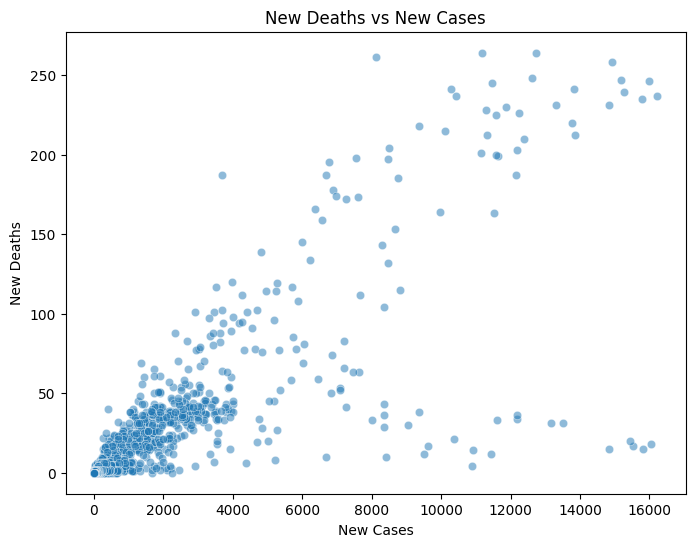

Correlation between new cases and new deaths: 0.810


In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='new_cases', y='new_deaths', data=bd_data, alpha=0.5)
plt.title('New Deaths vs New Cases')
plt.xlabel('New Cases')
plt.ylabel('New Deaths')
plt.show()

corr = bd_data[['new_cases', 'new_deaths']].corr().iloc[0,1]
print(f"Correlation between new cases and new deaths: {corr:.3f}")


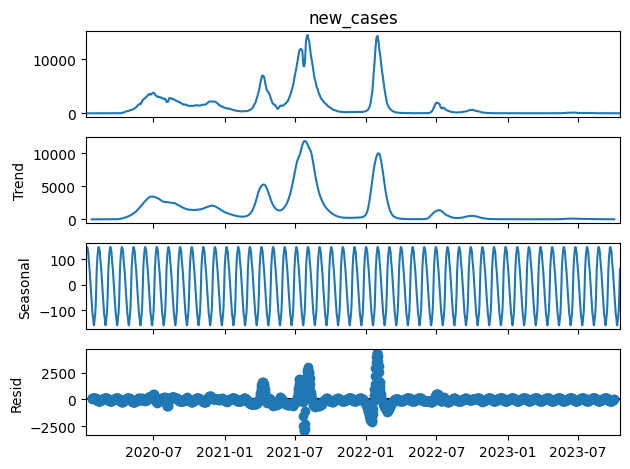

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

bd_data_indexed = bd_data.set_index('date')
result = seasonal_decompose(bd_data_indexed['new_cases'].rolling(window=7).mean().dropna(), model='additive', period=30)

result.plot()
plt.show()



The time series plot reveals waves and peaks of COVID-19 cases.

The 7-day moving average smooths daily fluctuations.

Distribution is right-skewed (many days with low cases, few with high spikes).

Monthly aggregation shows clear peaks corresponding to COVID waves.

Positive correlation between new cases and deaths confirms severity trends.

Seasonal decomposition may reveal any recurring weekly/monthly patterns.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pymannkendall as mk
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.formula.api import ols

In [16]:
import pymannkendall as mk

result = mk.original_test(bd_data['new_cases'].values)
print("Mann-Kendall Trend Test:")
print(f"Trend: {result.trend}")
print(f"p-value: {result.p}")


Mann-Kendall Trend Test:
Trend: decreasing
p-value: 0.0


Interpretation:
This means there is a statistically significant decreasing trend in COVID-19 new cases over the analyzed time period in Bangladesh.

The p-value being effectively zero means we strongly reject the null hypothesis of no trend, confirming that cases have been going down overall.

In [17]:
# Load data


data = pd.read_csv("/media/kibria/624309e6-cae1-4eca-a603-4ebc61fc0d9b/data/archive/owid-covid-data.csv")

bd_data = data[data['location'] == 'Bangladesh'].copy()
bd_data['date'] = pd.to_datetime(bd_data['date'])
bd_data = bd_data[['date', 'new_cases', 'new_deaths']].fillna(0)

# Prepare numeric time variable for trend test
bd_data['day_num'] = (bd_data['date'] - bd_data['date'].min()).dt.days

In [18]:
from pymannkendall import original_test as mk_test

result = mk_test(bd_data['new_cases'].values)
print("Mann-Kendall Trend Test:")
print(f"Trend: {result.trend}")
print(f"p-value: {result.p}")


Mann-Kendall Trend Test:
Trend: decreasing
p-value: 0.0


In [19]:
corr, p_value = spearmanr(bd_data['new_cases'], bd_data['new_deaths'])
print(f"Spearman correlation between new cases and new deaths: {corr:.3f}, p-value: {p_value:.4f}")


Spearman correlation between new cases and new deaths: 0.910, p-value: 0.0000


 significant Correlation Between Cases and Deaths

<Figure size 1000x500 with 0 Axes>

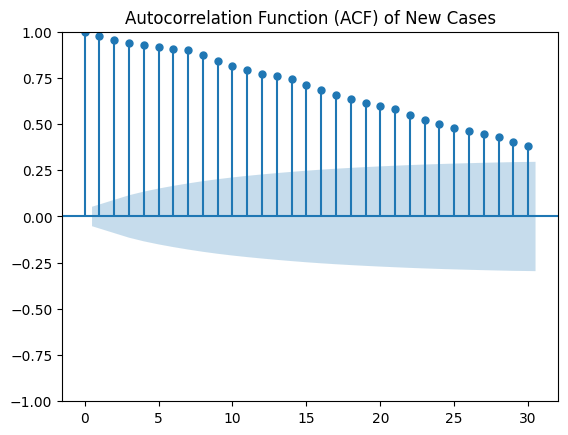

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,5))
plot_acf(bd_data['new_cases'], lags=30)
plt.title('Autocorrelation Function (ACF) of New Cases')
plt.show()


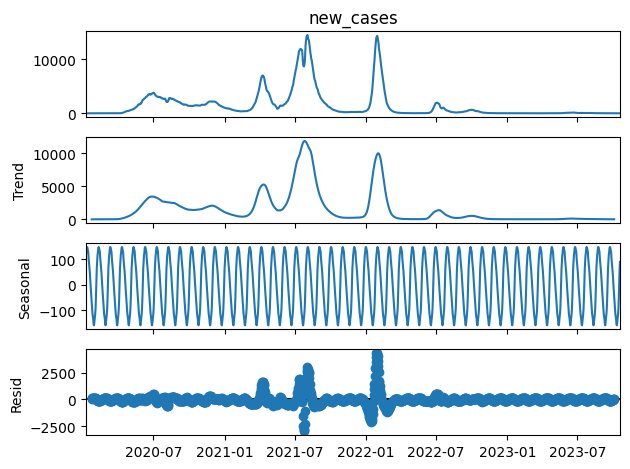

In [21]:
bd_data.set_index('date', inplace=True)
decomposition = seasonal_decompose(bd_data['new_cases'].rolling(7).mean().dropna(), model='additive', period=30)
decomposition.plot()
plt.show()


In [22]:
lockdown_date = pd.to_datetime('2021-07-01')

before = bd_data[bd_data.index < lockdown_date]['new_cases']
after = bd_data[bd_data.index >= lockdown_date]['new_cases']

from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(before, after, alternative='two-sided')
print(f"Mann-Whitney U test for cases before and after lockdown:")
print(f"p-value = {p:.4f}")


Mann-Whitney U test for cases before and after lockdown:
p-value = 0.0000


significant difference in median cases before and after lockdown.

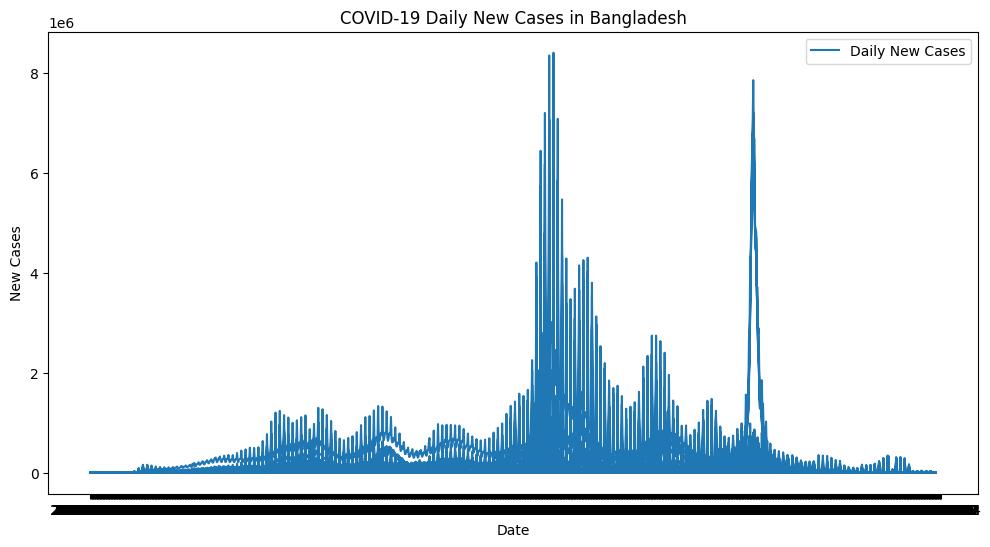

In [23]:
import matplotlib.pyplot as plt
df=data.copy()

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['new_cases'], label='Daily New Cases')
plt.title("COVID-19 Daily New Cases in Bangladesh")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.show()


In [24]:
df.shape

(350085, 67)

In [25]:
df.isnull().sum()

iso_code                                        0
continent                                   16665
location                                        0
date                                            0
total_cases                                 37997
                                            ...  
population                                      0
excess_mortality_cumulative_absolute       337901
excess_mortality_cumulative                337901
excess_mortality                           337901
excess_mortality_cumulative_per_million    337901
Length: 67, dtype: int64

In [26]:

df = df.dropna(subset=['new_cases'])


In [27]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Create numerical feature from date
df['day_num'] = (df['date'] - df['date'].min()).dt.days

# Reshape for sklearn
X = df['day_num'].values.reshape(-1,1)
y = df['new_cases'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Predict trend line
df['trend'] = model.predict(X)

plt.plot(df['date'], y, label='Actual Cases')
plt.plot(df['date'], df['trend'], label='Linear Trend', color='red')
plt.legend()
plt.show()


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
from prophet import Prophet

# Prepare data for Prophet
df_prophet = df.rename(columns={'date':'ds', 'new_cases':'y'})

# Initialize and fit model
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

# Make future dataframe for next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("COVID-19 Cases Forecast in Bangladesh")
plt.show()

# Plot forecast components
model.plot_components(forecast)
plt.show()


17:38:42 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))

             ds          yhat     yhat_lower     yhat_upper
1385 2023-10-19  -2559.962196 -133813.241906  135038.587732
1386 2023-10-20  -2138.458104 -145025.372789  126061.126635
1387 2023-10-21  -2775.464109 -143515.259661  127847.197171
1388 2023-10-22   9841.687549 -123928.398834  159729.049666
1389 2023-10-23  -4046.108455 -152802.347717  135625.377160
1390 2023-10-24  -4777.267538 -142234.462003  121569.385938
1391 2023-10-25  -3261.725042 -138547.227506  133198.674417
1392 2023-10-26  -2942.126139 -144337.732527  139201.544262
1393 2023-10-27  -2282.167323 -138221.666634  148992.114269
1394 2023-10-28  -2671.887521 -138719.116625  142771.284705
1395 2023-10-29  10193.306526 -132345.556534  149508.131080
1396 2023-10-30  -3454.043374 -138776.793334  136693.338844
1397 2023-10-31  -3960.729853 -147782.850375  146803.233265
1398 2023-11-01  -2244.827665 -143314.558924  135778.448806
1399 2023-11-02  -1756.620915 -138209.416203  135940.697458
1400 2023-11-03   -966.689035 -140666.52

: 

: 

: 

17:25:42 - cmdstanpy - INFO - Chain [1] start processing
17:26:41 - cmdstanpy - INFO - Chain [1] done processing


MAE on test set: 11330.12
RMSE on test set: 12337.11


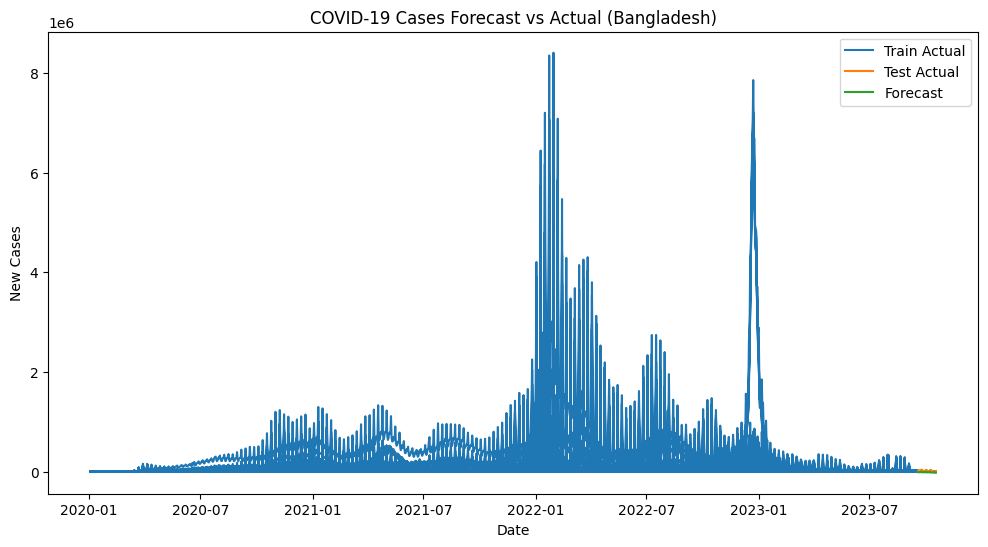

: 

: 

: 

In [ ]:
bd_data=df.copy()
# Define train/test split date (e.g., last 30 days for testing)
split_date = bd_data['date'].max() - pd.Timedelta(days=30)
train_df = bd_data[bd_data['date'] <= split_date]
test_df = bd_data[bd_data['date'] > split_date]

# Prepare Prophet training data
train_prophet = train_df.rename(columns={'date':'ds', 'new_cases':'y'})

# Train Prophet model
model = Prophet(daily_seasonality=True)
model.fit(train_prophet)

# Create future dataframe for the test period
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Extract forecast for test period only
forecast_test = forecast[forecast['ds'] > split_date]

# Merge forecast with actual test data
comparison_df = test_df.merge(forecast_test[['ds', 'yhat']], left_on='date', right_on='ds')

# Calculate error metrics
mae = mean_absolute_error(comparison_df['new_cases'], comparison_df['yhat'])
rmse = np.sqrt(mean_squared_error(comparison_df['new_cases'], comparison_df['yhat']))

print(f"MAE on test set: {mae:.2f}")
print(f"RMSE on test set: {rmse:.2f}")

# Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(train_df['date'], train_df['new_cases'], label='Train Actual')
plt.plot(test_df['date'], test_df['new_cases'], label='Test Actual')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.title('COVID-19 Cases Forecast vs Actual (Bangladesh)')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# Sort by date
df = df.sort_values('date').reset_index(drop=True)

# Create lag features (last 7 days cases)
for lag in range(1, 8):
    df[f'lag_{lag}'] = df['new_cases'].shift(lag)

# Drop rows with NaN after lagging
df = df.dropna().reset_index(drop=True)

# Features and target
features = [f'lag_{lag}' for lag in range(1, 8)]
X = df[features]
y = df['new_cases']

# Split train/test (e.g., last 30 days for testing)
train_size = len(df) - 30
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Initialize and train XGBoost regressor WITHOUT early stopping
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(df['date'].iloc[train_size:], y_test, label='Actual Cases', marker='o')
plt.plot(df['date'].iloc[train_size:], y_pred, label='Predicted Cases', marker='x')
plt.title('XGBoost COVID-19 New Cases Prediction (Bangladesh)')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()


NameError: name 'df' is not defined

: 

: 

: 

: 

: 

: 

: 

: 